In [1]:
import sys,os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score,average_precision_score,brier_score_loss,log_loss

from data.uci.loader import load_uci_data
from data.uci.feature_mapper import map_uci_features
from data.uci.label_mapper import map_uci_label

from pipelines.uci_pipeline import build_uci_gb_pipeline

In [8]:
#Loading the data
data_path = "../data/raw/uci/uci_data.xls"
uci_df = load_uci_data(data_path)
y = map_uci_label(uci_df)
X_raw = uci_df.drop(columns=["ID","default payment next month"],errors="ignore")


In [9]:
#Splitting the whole dataset for training - calibration - testing
#sklearn train_test_split can split data only 2,
#So at first we will create a train set and temporary set
#From temporary set , we will again divide 2 into cal and test

X_train,X_temp,y_train,y_temp = train_test_split(X_raw,y,stratify=y,test_size=0.3,random_state=42)

In [10]:
X_cal,X_test,y_cal,y_test = train_test_split(X_temp,y_temp,stratify=y_temp,random_state=42,test_size=0.50)

In [11]:
print(f"Split sizes",len(X_train),len(X_cal),len(X_test))

Split sizes 21000 4500 4500


In [12]:
#Training on my base model
base_pipe = build_uci_gb_pipeline(random_state=42)
base_pipe.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature', ...), ('prep', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

In [13]:
p_cal = base_pipe.predict_proba(X_cal)[:,1]

In [14]:
p_cal

array([0.25036548, 0.36179623, 0.20449653, ..., 0.1055118 , 0.15228119,
       0.43264213], shape=(4500,))

In [15]:
#Now we will pair raw probability and actual using cal and learn what to correct
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

frozen_model = FrozenEstimator(base_pipe)
calibrator = CalibratedClassifierCV(estimator=frozen_model,method="sigmoid",cv=None)
calibrator.fit(X_cal,y_cal)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",FrozenEstimat..._state=42))]))
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the co

In [16]:
X_test_prob_raw = base_pipe.predict_proba(X_test)[:,1]
X_test_prob_cal = calibrator.predict_proba(X_test)[:,1]

In [17]:
from sklearn.metrics import brier_score_loss,log_loss

brier_loss_base = brier_score_loss(y_test,X_test_prob_raw)
brier_loss_cal = brier_score_loss(y_test,X_test_prob_cal)

log_loss_base = log_loss(y_test,X_test_prob_raw)
log_loss_cal = log_loss(y_test,X_test_prob_cal)



In [18]:
print("brier loss base : ",brier_loss_base)
print("brier loss cal : ",brier_loss_cal)
print("log loss base : ",log_loss_base)
print("log loss cal : ",log_loss_cal)


brier loss base :  0.14078870413817765
brier loss cal :  0.1407436728359307
log loss base :  0.44293955422810205
log loss cal :  0.44276161753532356


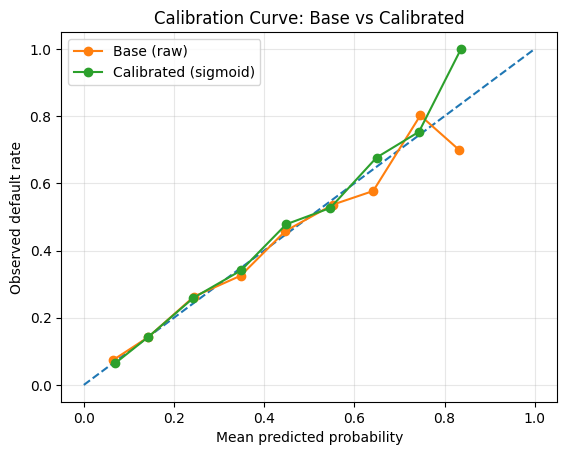

In [19]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true_base, prob_pred_base = calibration_curve(y_test, X_test_prob_raw, n_bins=10, strategy="uniform")
prob_true_cal,  prob_pred_cal  = calibration_curve(y_test, X_test_prob_cal,  n_bins=10, strategy="uniform")

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")  # perfect calibration line

plt.plot(prob_pred_base, prob_true_base, marker="o", label="Base (raw)")
plt.plot(prob_pred_cal,  prob_true_cal,  marker="o", label="Calibrated (sigmoid)")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration Curve: Base vs Calibrated")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
